<a href="https://colab.research.google.com/github/Angelvj/TFG/blob/main/code/jupyter/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
!pip install -q -U keras-tuner
import kerastuner as kt

import keras
import keras.layers as layers
import numpy as np
import tensorflow as tf
import keras as k
import sklearn
import nibabel as nib
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, MaxPool3D, GlobalAveragePooling3D, AveragePooling3D
from keras.utils import to_categorical
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import SGD

import time
import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import svm
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import LinearSVC
from sklearn import decomposition
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load data and impute NaN values

In [2]:
# Load data
COLAB = True
preprocessed = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_PATH = '/content/drive/My Drive/Machine learning/data'
  if preprocessed:
      DATA_PATH += '/preprocessed'

else: 
  DATA_PATH = '../../data'

def load_image(filename):    
    """
    
    Parameters
    ----------
    filename : str
        relative path to de image

    Returns
    -------
    img : numpy ndarray
        array containing the image
        
    """
    img = nib.load(filename)
    img = np.asarray(img.dataobj)
    img = np.expand_dims(img, axis=3)
    return img


def load_images_from_dir(dirname):
    """
    
    Parameters
    ----------
    dirname : str
        name of the directory containing images.

    Returns
    -------
    imgs : numpy ndarray
        array containing all of the images in the folder.

    """
    imgs = []

    for filename in tqdm(glob.glob(dirname + '/*.nii')):
        imgs.append(load_image(filename))
        
    imgs = np.stack(imgs) # All images over the new first dimension
    return imgs

def load_data(dirs_dict, categorical = False):
    """
    
    Parameters
    ----------
    dirs_dict : dictionary
        dictionary containing data folders name, and the label for the images
        on each forlder.

    Returns
    -------
    x : numpy ndarray
        array containing the images.
    y : numpy ndarray

        array containig the label of each image.

    """
    first = True
    for key, value in dirs_dict.items():
        if first:
            X = load_images_from_dir(value)
            # ¿necesario float32 o puedo usar uint8?
            y = np.full((X.shape[0]), key, dtype=np.float32)
            first = False
        else:
            X_current = load_images_from_dir(value)
            X = np.concatenate((X, X_current), axis=0)
            y = np.concatenate((y, np.full((X_current.shape[0]), key, dtype=np.float32)), axis=0)
            
    if categorical:
        y = k.utils.to_categorical(y)
    
    return X, y

def impute_nan_values(imgs, inplace=True):
    # Replace nan values with 0
    return np.nan_to_num(imgs, copy = not inplace)

# Load PET images with labels
print('\n --- Loading PET data --- \n')
time.sleep(0.5)
X, y = load_data({0: DATA_PATH + "/ppNOR/PET", 
                  1: DATA_PATH + "/ppAD/PET",
                  2: DATA_PATH + "/ppMCI/PET"})

# Separate into training and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 1)

impute_nan_values(X_train)
impute_nan_values(X_test)

print('\n --- PET data loaded --- \n')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 --- Loading PET data --- 



100%|██████████| 111/111 [00:00<00:00, 313.43it/s]



 --- PET data loaded --- 



# Preprocessing data

In [3]:
def max_intensity_normalization(X, percentage, inplace=True):

    if not inplace:
        X = X.copy()

    volume_shape = X[0].shape
    n_max_values = int((volume_shape[0]*volume_shape[1]*volume_shape[2]*percentage)/100)

    for i in range(len(X)):
        n_max_idx = np.unravel_index((X[i]).argsort(axis=None)[-n_max_values:], X[i].shape)
        mean = np.mean(X[i][n_max_idx])
        X[i] /= mean

    if not inplace:
        return X

X_train_n = max_intensity_normalization(X_train, 1, inplace=False)

# Testing SVM

In [4]:
# # Test SVM classifier first
# x_tr, x_val, y_tr, y_val = train_test_split(X_train_n, y_train, test_size = 0.2, stratify = y_train)

# x_tr_1D = np.empty((x_tr.shape[0], x_tr.shape[1]*x_tr.shape[2]*x_tr.shape[3]))

# # Convert each image to a single dimension ndarray
# for i in range(len(x_tr)):
#     x_tr_1D[i] = x_tr[i].flatten()

# x_val_1D = np.empty((x_val.shape[0], x_val.shape[1]*x_val.shape[2]*x_val.shape[3]))
# for i in range(len(y_val)):
#     x_val_1D[i] = x_val[i].flatten()

# # clf = svm.SVC(kernel='linear', C=0.8)
# # clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=0.05)) # 0.48 en 5 tiradas
# # clf.fit(x_tr_1D, y_tr)

# print(clf.score(x_tr_1D, y_tr))
# print(clf.score(x_val_1D, y_val))

# Functions for training models

In [5]:
def learning_curve(hist):
    history_dict = hist.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.ylim(0 - 0.1, 6 + 0.1)
    plt.legend(['Training', 'Validation'])
    plt.show()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.ylim(0 -0.1, 1 + 0.1)
    plt.legend(['Training','Validation'])
    plt.show()

In [6]:
def cross_validate(model, x_train, y_train, num_folds, opt, batch_size, epochs, verbose=0, show_history=False, return_results=True):

    # Creamos un objeto kfold, especificando el número de segmentos que queremos utilizar,
    # además utilizamos shuffle true, para que los num_folds conjuntos disjuntos se seleccionen
    # de forma aleatoria, evitando de esta forma problemas que podría haber si los datos
    # estuvieran ordenados siguiendo una cierta distribución

    skfold = StratifiedKFold(n_splits = num_folds, shuffle=True)

    model.compile(loss = k.losses.categorical_crossentropy, optimizer=opt,
                metrics = ['accuracy'])

    initial_weights = model.get_weights()

    acc_per_fold = []
    loss_per_fold = []
    acc_per_fold_tr = []
    loss_per_fold_tr = []

    fold_no = 1

    for kfold_train, kfold_test in skfold.split(x_train, y_train):

        # En cada fold, comenzamos con los pesos iniciales. Tratamos de que las 5
        # folds sean lo más independientes posible.
        model.set_weights(initial_weights)

        if verbose:
            print('------------------------------------------------------------------------')
            print(f'Entrenando para el fold {fold_no} ...')

        history = model.fit(x_train[kfold_train], 
                            k.utils.to_categorical(y_train[kfold_train]), 
                            batch_size= batch_size,
                            epochs=epochs, verbose = verbose, 
                            validation_data = (x_train[kfold_test], k.utils.to_categorical(y_train[kfold_test]))
                            )

        if show_history:
            # Mostramos la evolución en cada fold
            learning_curve(history)

        # Calculamos la bondad del modelo para el fold reservado para testing
        scores = model.evaluate(x_train[kfold_test], k.utils.to_categorical(y_train[kfold_test]), verbose=0)
        scores_train = model.evaluate(x_train[kfold_train], k.utils.to_categorical(y_train[kfold_train]), verbose=0)

        # Vamos guardando el accuracy y pérdida para cada fold
        acc_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        acc_per_fold_tr.append(scores_train[1])
        loss_per_fold_tr.append(scores_train[0])

        if verbose:
            print(f'Resultado para el fold {fold_no}: {model.metrics_names[0]} de {scores[0]}; {model.metrics_names[1]} de {scores[1]*100}%')

        fold_no += 1

    # ==  Mostramos los valores medios == 
    if verbose:
        print('------------------------------------------------------------------------')
        print('Resultados por cada fold')
        for i in range(0, len(acc_per_fold)):
            print('------------------------------------------------------------------------')
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')

    mean_acc_cv = np.mean(acc_per_fold)
    mean_loss_cv = np.mean(loss_per_fold)
    mean_acc_tr = np.mean(acc_per_fold_tr)
    mean_loss_tr = np.mean(loss_per_fold_tr)

    if not return_results:
        print('------------------------------------------------------------------------')
        print('Media de los resultados para todos los folds:')
        print(f'> Accuracy: {np.mean(acc_per_fold)}')
        print(f'> Loss: {np.mean(loss_per_fold)}')
        print(f'> Train accuracy: {np.mean(acc_per_fold_tr)}')
        print(f'> Train accuracy: {np.mean(loss_per_fold_tr)}')
        print('------------------------------------------------------------------------')

    else:
        return mean_acc_tr, mean_loss_tr, mean_acc_cv, mean_loss_cv

In [7]:
!rm -r ./basic\_model

rm: cannot remove './basic_model': No such file or directory


# Hypertuning

In [8]:
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values=[4, 8, 16])
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [9]:
'''
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256. The optimal learning rate for the optimizer
is 0.0001. The optimal batch size is 4
'''
def model_zero_builder(hp, width=79, height=95, depth=68):
     
    model = keras.Sequential()

    model.add(Conv3D(filters=32, kernel_size=3, activation="relu", input_shape = (width, height, depth, 1)))
    model.add(MaxPooling3D(pool_size=2))

    model.add(Flatten())

    hp_units = hp.Choice('units', values=[64, 128, 256])
    model.add(Dense(units=hp_units, activation="relu"))

    model.add(Dense(units=3, activation="softmax"))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5, 1e-6])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss = keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])

    return model

# tuner = MyTuner(basic_model_builder, 
#                 objective='val_loss',
#                 project_name = 'basic_model',
#                 max_trials = 100)

# tuner.search(X_train_n, k.utils.to_categorical(y_train), epochs=30, validation_split=0.2)

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')}. The optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}. The optimal batch size is {best_hps.get('batch_size')}
# """)

# Best hyperparameters for second model
# 32 32 128
# 5 3 5
def second_model_builder(hp, width=79, height=95, depth=68):
    inputs = k.Input((width, height, depth, 1))

    hp_filter_size_1 = hp.Choice('ks_1', values=[3,5])
    hp_filters_1 = hp.Choice('filters_1', values=[8, 16, 32])
    x = Conv3D(filters=hp_filters_1, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)

    hp_filter_size_2 = hp.Choice('ks_2', values=[3,5])
    hp_filters_2 = hp.Choice('filters_2', values=[16, 32, 64])
    x = Conv3D(filters=hp_filters_2, kernel_size=hp_filter_size_2, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    hp_filter_size_3 = hp.Choice('ks_3', values=[3,5])
    hp_filters_3 = hp.Choice('filters_3', values=[16, 64, 128])
    x = Conv3D(filters=hp_filters_3, kernel_size=hp_filter_size_3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = k.Model(inputs, outputs, name="second_model_builder")


    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss = keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    
    return model

# print(best_hps.get('filters_1'), best_hps.get('filters_2'), best_hps.get('filters_3'))
# print(best_hps.get('ks_1'), best_hps.get('ks_2'), best_hps.get('ks_3'))

# Define models


 --------------- MODELO 1 ------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 79, 95, 68, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 77, 93, 66, 32)    896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 38, 46, 33, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 36, 44, 31, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 18, 22, 15, 32)    0         
_________________________________________________________________
flatten (Flatten)            (None, 190080)            0         
_________________________________________________________________
dense (Dense

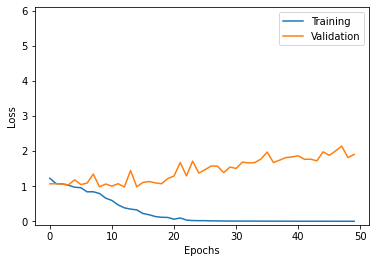

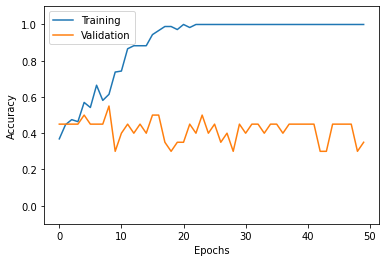

Resultado para el fold 1: loss de 1.907055139541626; accuracy de 34.99999940395355%
------------------------------------------------------------------------
Entrenando para el fold 2 ...
Epoch 1/50
45/45 [==============================] - 2s 51ms/step - loss: 1.4035 - accuracy: 0.4134 - val_loss: 1.0849 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 2s 50ms/step - loss: 1.0569 - accuracy: 0.4469 - val_loss: 1.0655 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0497 - accuracy: 0.4525 - val_loss: 1.0378 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0220 - accuracy: 0.4525 - val_loss: 1.0020 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 2s 51ms/step - loss: 0.9852 - accuracy: 0.5084 - val_loss: 1.0038 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 2s 51ms/step - loss: 0.9387 - accuracy: 0.5978 - val_los

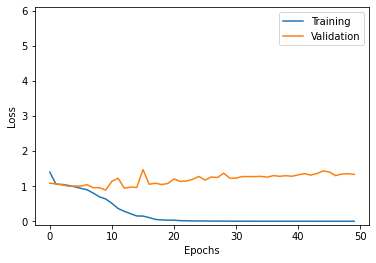

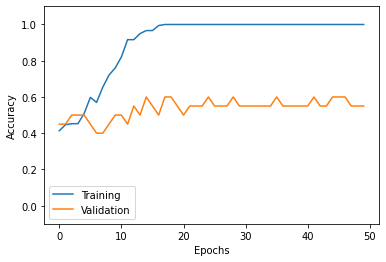

Resultado para el fold 2: loss de 1.336449146270752; accuracy de 55.000001192092896%
------------------------------------------------------------------------
Entrenando para el fold 3 ...
Epoch 1/50
45/45 [==============================] - 2s 51ms/step - loss: 1.4098 - accuracy: 0.4078 - val_loss: 1.0769 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 2s 50ms/step - loss: 1.0696 - accuracy: 0.4469 - val_loss: 1.0621 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0507 - accuracy: 0.4469 - val_loss: 1.0505 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 2s 50ms/step - loss: 1.0401 - accuracy: 0.4804 - val_loss: 1.0480 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0281 - accuracy: 0.4972 - val_loss: 1.0279 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0310 - accuracy: 0.4749 - val_lo

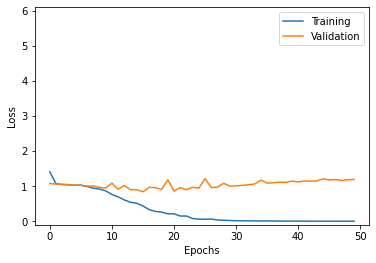

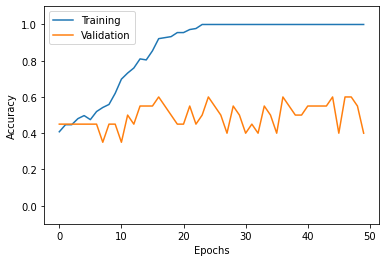

Resultado para el fold 3: loss de 1.1940666437149048; accuracy de 40.00000059604645%
------------------------------------------------------------------------
Entrenando para el fold 4 ...
Epoch 1/50
45/45 [==============================] - 2s 52ms/step - loss: 1.3552 - accuracy: 0.3911 - val_loss: 1.0721 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0667 - accuracy: 0.4469 - val_loss: 1.0615 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0502 - accuracy: 0.4469 - val_loss: 1.0571 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0432 - accuracy: 0.4581 - val_loss: 1.0602 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0230 - accuracy: 0.4581 - val_loss: 1.0408 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 2s 51ms/step - loss: 0.9708 - accuracy: 0.4972 - val_lo

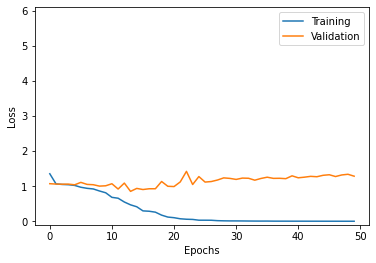

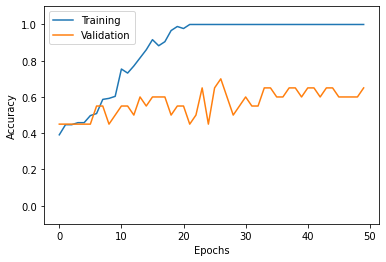

Resultado para el fold 4: loss de 1.2858424186706543; accuracy de 64.99999761581421%
------------------------------------------------------------------------
Entrenando para el fold 5 ...
Epoch 1/50
45/45 [==============================] - 2s 51ms/step - loss: 1.2419 - accuracy: 0.4022 - val_loss: 1.0779 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 2s 50ms/step - loss: 1.0744 - accuracy: 0.4469 - val_loss: 1.0705 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0541 - accuracy: 0.4525 - val_loss: 1.0853 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0333 - accuracy: 0.4637 - val_loss: 1.0780 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 2s 50ms/step - loss: 1.0012 - accuracy: 0.5028 - val_loss: 1.0920 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 2s 50ms/step - loss: 0.9683 - accuracy: 0.4972 - val_lo

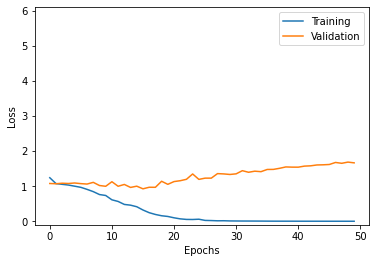

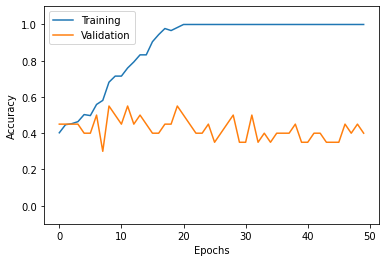

Resultado para el fold 5: loss de 1.6661252975463867; accuracy de 40.00000059604645%
------------------------------------------------------------------------
Entrenando para el fold 6 ...
Epoch 1/50
45/45 [==============================] - 2s 52ms/step - loss: 1.1972 - accuracy: 0.3687 - val_loss: 1.0685 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0656 - accuracy: 0.4804 - val_loss: 1.0749 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0676 - accuracy: 0.4525 - val_loss: 1.2770 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0735 - accuracy: 0.4469 - val_loss: 1.0190 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0208 - accuracy: 0.4637 - val_loss: 1.0264 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 2s 51ms/step - loss: 0.9969 - accuracy: 0.4916 - val_lo

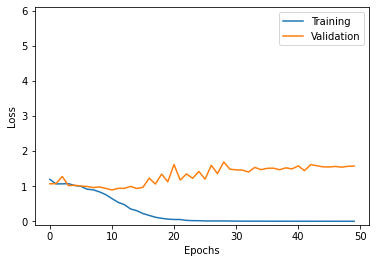

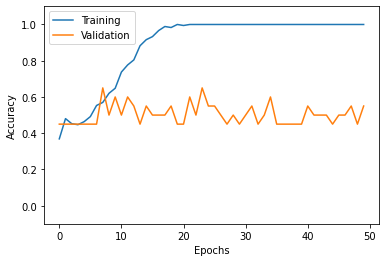

Resultado para el fold 6: loss de 1.5752743482589722; accuracy de 55.000001192092896%
------------------------------------------------------------------------
Entrenando para el fold 7 ...
Epoch 1/50
45/45 [==============================] - 2s 51ms/step - loss: 1.3804 - accuracy: 0.3966 - val_loss: 1.0801 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0701 - accuracy: 0.4469 - val_loss: 1.0606 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0542 - accuracy: 0.4525 - val_loss: 1.0482 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0725 - accuracy: 0.4469 - val_loss: 1.0356 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0242 - accuracy: 0.4581 - val_loss: 1.0223 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 2s 51ms/step - loss: 0.9971 - accuracy: 0.4916 - val_l

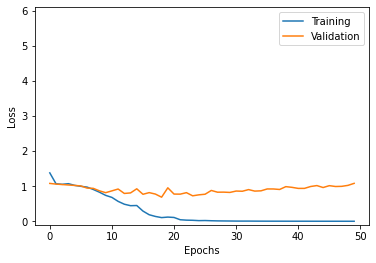

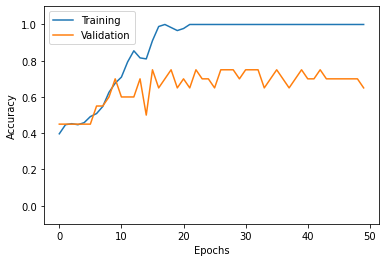

Resultado para el fold 7: loss de 1.0818214416503906; accuracy de 64.99999761581421%
------------------------------------------------------------------------
Entrenando para el fold 8 ...
Epoch 1/50
45/45 [==============================] - 2s 52ms/step - loss: 1.7532 - accuracy: 0.3743 - val_loss: 1.0926 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 2s 50ms/step - loss: 1.0817 - accuracy: 0.4469 - val_loss: 1.0487 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0648 - accuracy: 0.4469 - val_loss: 1.0551 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0504 - accuracy: 0.4581 - val_loss: 1.0519 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0447 - accuracy: 0.4637 - val_loss: 1.0543 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0075 - accuracy: 0.4804 - val_lo

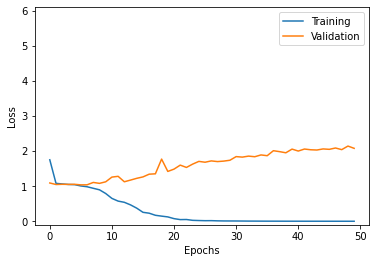

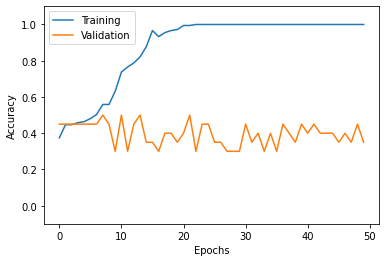

Resultado para el fold 8: loss de 2.0802321434020996; accuracy de 34.99999940395355%
------------------------------------------------------------------------
Entrenando para el fold 9 ...
Epoch 1/50
45/45 [==============================] - 2s 51ms/step - loss: 1.7356 - accuracy: 0.4022 - val_loss: 1.0837 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0859 - accuracy: 0.4469 - val_loss: 1.0763 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0709 - accuracy: 0.4469 - val_loss: 1.0577 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0457 - accuracy: 0.4469 - val_loss: 1.0392 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0231 - accuracy: 0.4525 - val_loss: 1.0276 - val_accuracy: 0.5000
Epoch 6/50
45/45 [==============================] - 2s 51ms/step - loss: 0.9970 - accuracy: 0.4749 - val_lo

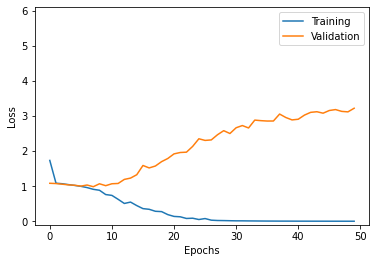

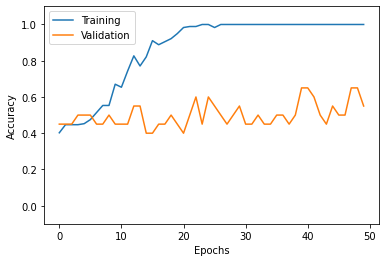

Resultado para el fold 9: loss de 3.223644256591797; accuracy de 55.000001192092896%
------------------------------------------------------------------------
Entrenando para el fold 10 ...
Epoch 1/50
45/45 [==============================] - 3s 52ms/step - loss: 1.2263 - accuracy: 0.3778 - val_loss: 1.0924 - val_accuracy: 0.4211
Epoch 2/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0698 - accuracy: 0.4500 - val_loss: 1.0858 - val_accuracy: 0.4211
Epoch 3/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0405 - accuracy: 0.4611 - val_loss: 1.0882 - val_accuracy: 0.4211
Epoch 4/50
45/45 [==============================] - 2s 51ms/step - loss: 1.0144 - accuracy: 0.5167 - val_loss: 1.0782 - val_accuracy: 0.4211
Epoch 5/50
45/45 [==============================] - 2s 51ms/step - loss: 0.9240 - accuracy: 0.6333 - val_loss: 1.0954 - val_accuracy: 0.4211
Epoch 6/50
45/45 [==============================] - 2s 51ms/step - loss: 0.9181 - accuracy: 0.5444 - val_l

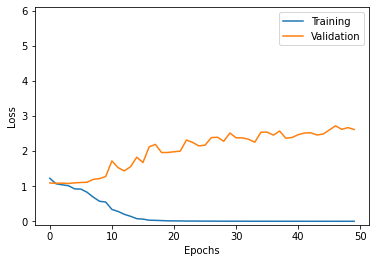

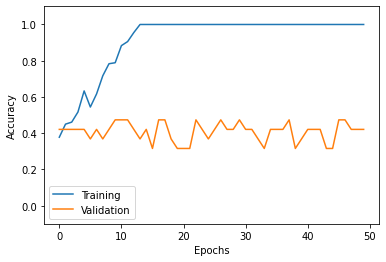

Resultado para el fold 10: loss de 2.617565870285034; accuracy de 42.105263471603394%
------------------------------------------------------------------------
Resultados por cada fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.907055139541626 - Accuracy: 0.3499999940395355%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.336449146270752 - Accuracy: 0.550000011920929%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1940666437149048 - Accuracy: 0.4000000059604645%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.2858424186706543 - Accuracy: 0.6499999761581421%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.6661252975463867 - Accuracy: 0.4000000059604645%
------------------------------------------------------------------------
> Fold 6 - Loss: 1.5752743482589722 - Acc

In [18]:
# CNN MODELS

# Model configuration
sample_shape = (79,95,68,1)
no_classes = 3

def get_model_zero(width=79, height=95, depth=68):
    # 10-fold cross validation results:
    #                   Accuracy                    Loss
    # With dropout      0.4728947371244431          1.5121068477630615
    # No dropout        0.4921052664518356          1.3477824926376343
    # No drop. 64u      0.45210526287555697         1.35818772315979 -->
    # Train 0.88 acc vs 1.0 in previous models

    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)

    x = MaxPooling3D(pool_size=2)(x)  

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x) 
    # x = Dropout(0.5)(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = k.Model(inputs, outputs, name="model_0")
    return model


def get_model_one(width=79, height=95, depth=68):
# (1.0, 0.0019101470068562775, 0.5381578862667084, 1.8131330549716949)
    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)

    x = MaxPooling3D(pool_size=2)(x)  

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(x)

    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x) 

    outputs = Dense(units=3, activation="softmax")(x)

    model = k.Model(inputs, outputs, name="model_1")
    return model

def get_second_model(width=79, height=95, depth=68):
    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=8, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=16, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = k.Model(inputs, outputs, name="model_2")
    return model

# Fit model to data
# Batch size of 16 as a standard starting point: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ ?

# print('\n --------------- MODELO 0 ------------------\n')
# # Ya tiene los mejores hiperparámetros ajustados
# model = get_model_zero()
# model.summary()
# results = cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.0001), 4, 50, 
#                verbose = 1, show_history = True)
# print(results)
# keras.backend.clear_session()

print('\n --------------- MODELO 1 ------------------\n')
# Ya tiene los mejores hiperparámetros ajustados
model = get_model_one()
model.summary()
results = cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.0001), 4, 50, 
               verbose = 1, show_history = True)
print(results)
keras.backend.clear_session()

# print('\n --------------- MODELO 2 ------------------\n')
# model = get_second_model()
# model.summary()


# results = cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.0001), 4, 50, 
#                verbose = 1, show_history = True)

# keras.backend.clear_session()


# print('\n --------------- MODELO 3 ------------------\n')
# model = get_model(3)
# model.summary()

# # opt = SGD(lr = 0.001, momentum = 0.9, nesterov = True)
# results = cross_validate(model, X_train_n, y_train, 5,  k.optimizers.Adam(), 16, 30, 
#                verbose = 1, show_history = False)
# print(results)
# keras.backend.clear_session()

In [11]:
# Models to be tested
# def get_first_model(width=79, height=95, depth=68):
#     '''
#     Deeper model, 
#     '''
#     inputs = k.Input((width, height, depth, 1))

#     x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
#     # x = BatchNormalization()(x)

#     x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = MaxPooling3D(pool_size=2)(x)
#     # x = BatchNormalization()(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     # x = BatchNormalization()(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = MaxPooling3D(pool_size=2)(x)
#     # x = BatchNormalization()(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     # x = BatchNormalization()(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = GlobalAveragePooling3D()(x)

#     x = Dense(units=512, activation="relu")(x)

#     outputs = Dense(units=3, activation="softmax")(x)

#     model = k.Model(inputs, outputs, name="baseline_3Dcnn")
#     return model

# def get_first_model(width=79, height=95, depth=68):
#     """Build a 3D convolutional neural network model."""

#     inputs = keras.Input((width, height, depth, 1))

#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization(momentum=0.0)(x)

#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization(momentum=0.0)(x)

#     x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization(momentum=0.0)(x)

#     x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization(momentum=0.0)(x)

#     x = layers.GlobalAveragePooling3D()(x)
#     x = layers.Dense(units=512, activation="relu")(x)
#     x = layers.Dropout(0.3)(x)

#     outputs = layers.Dense(units=3, activation="softmax")(x)

#     # Define the model.
#     model = keras.Model(inputs, outputs, name="3dcnn")
#     return model


# def get_fourth_model(width=79, height=95, depth=68):

#     inputs = k.Input((width, height, depth, 1))

#     x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
#     x = MaxPooling3D(pool_size=2)(x)
#     x = Dropout(0.1)(x)

#     x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = MaxPooling3D(pool_size=2)(x)
#     x = Dropout(0.1)(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = MaxPooling3D(pool_size=2)(x)
#     x = Dropout(0.1)(x)

#     x = Flatten()(x)
#     x = Dense(units=256, activation="relu")(x)
#     x = Dropout(0.1)(x)

#     outputs = Dense(units=3, activation="softmax")(x)
#     x = Dropout(0.5)(x)

#     model = k.Model(inputs, outputs, name="baseline_3Dcnn")
#     return model